# Generalized linear mixed model (GLMM) với Keras

### BS. Lê Ngọc Khả Nhi

# Giới thiệu

Thân chào các bạn, trong bài thực hành hôm nay Nhi làm một thí nghiệm với mục tiêu dùng Neural network như công cụ suy diễn thống kê với tính năng như một mô hình Generalized linear mixed model (GLMM).

## Tóm tắt về GLMM

Trước hết, Nhi tóm tắt lại khái niệm về mô hình GLMM:

Như ta biết, mô hình tuyến tính tổng quát (GLM) có dạng: $\mathbf{y} = \mathbf{X}\beta + \epsilon$, trong đó $\mathbf{X}$ tương ứng với tập hợp các hiệu ứng chính của các hiệp biến/biến độc lập đối với variance của biến kết quả/phụ thuộc $\mathbf{y}$. Những hiệu ứng chính này được khảo sát qua giá trị của các coefficients $\beta$, còn $\epsilon$ tương ứng với giá trị nhiễu/sai số ngẫu nhiên, với giả định là $\epsilon\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$

Mô hình tuyến tính hỗn hợp (Mixed linear model hay GLMM) là một sự mở rộng của mô hình GLM, bằng cách đưa thêm vào một nhóm hiệu ứng ngẫu nhiên (random effect) $\mathbf{Z}\eta$, trong đó $\mathbf{Z}$ tương ứng với tập hợp các yếu tố ngẫu nhiên (phân nhóm), đo bằng coefficients $\eta$. Lúc này nội dung mô hình GLMM trở thành: \begin{aligned} \eta &\sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I}), \\ \mathbf{y} &= \mathbf{X}\beta + \mathbf{Z}\eta + \epsilon.\end{aligned}

Cách suy luận thống kê với GLMM cũng tương tự GLM, đó là dựa vào dữ liệu, ta sẽ xác định giá trị của $\beta$, $\eta$, và $\sigma^2$, trong đó $\beta$ được gọi là 'hiệu ứng chinh' (fixed effects), còn $\eta$ được gọi là hiệu ứng ngẫu nhiên hay bất định (random/latent effect). Trung bình của biến kết quả $\mathbf{y}$ được ước lượng chủ yếu bằng các hiệu ứng chính $\mathbf{X}\beta$, còn nhiệm vụ của $\eta$ là giải thích càng nhiều càng tốt sai số ngẫu nhiên, vốn được cho là nhiễu trong $\epsilon$ của mô hình GLM. 

## Dùng neural network mô phỏng GLMM

Trong các bài hoc nhập môn Deep learning (với tensorflow hay Keras), chúng ta đã thấy có thể dùng Neural network như một mô hình GLM, bao gồm logistic model. Như vậy, ta hoàn toàn có thể dùng Neural network như một mô hình GLMM vì so với GLM, GLMM chỉ có thêm 1 bộ phận Z bên cạnh X. 

Trong bài này, ta sẽ dùng Keras (tensorflow backend) để dựng một neural network có tính năng như một mô hình GLMM

Ta dùng dữ liệu minh họa từ nghiên cứu 'University Lecture/Instructor Evaluations by Students at ETH', được trích xuất từ Rpackage lme4.

Nội dung dữ liệu như sau:

'''
University lecture evaluations by students at ETH Zurich, anonymized for privacy protection. This is an interesting “medium” sized example of a partially nested mixed effect model.

A data frame with 73421 observations on the following 7 variables.

s = a factor with levels 1:2972 denoting individual students.

d = a factor with 1128 levels from 1:2160, denoting individual professors or lecturers.

studage = an ordered factor with levels 2 < 4 < 6 < 8, denoting student's “age” measured in the semester number the student has been enrolled.

lectage
an ordered factor with 6 levels, 1 < 2 < ... < 6, measuring how many semesters back the lecture rated had taken place.

service = a binary factor with levels 0 and 1; a lecture is a “service”, if held for a different department than the lecturer's main one.

dept = a factor with 14 levels from 1:15, using a random code for the department of the lecture.

y = a numeric vector of ratings of lectures by the students, using the discrete scale 1:5, with meanings of ‘poor’ to ‘very good’.

Each observation is one student's rating for a specific lecture (of one lecturer, during one semester in the past).

'''

In [21]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Input, Add, Dense
from keras import backend as K
from keras.callbacks import EarlyStopping

Ta tải dữ liệu về và tạo dataframe df có nội dung như sau:

In [23]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/lme4/InstEval.csv', index_col=0)

df.columns = ["Student","Lecturer","Stud_Age","Lect_Age","Service","Dept","Score"]

df["Student"] = df["Student"].astype('category')
df["Lecturer"] = df["Lecturer"].astype('category')
df["Dept"] = df["Dept"].astype('category')

df["Stud_Age"] = df["Stud_Age"].astype('object')
df["Lect_Age"] = df["Lect_Age"].astype('object')
df["Service"] = df["Service"].astype('object')

df["Score"] = df["Score"].astype('float')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73421 entries, 1 to 73421
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Student   73421 non-null  category
 1   Lecturer  73421 non-null  category
 2   Stud_Age  73421 non-null  object  
 3   Lect_Age  73421 non-null  object  
 4   Service   73421 non-null  object  
 5   Dept      73421 non-null  category
 6   Score     73421 non-null  float64 
dtypes: category(3), float64(1), object(3)
memory usage: 3.3+ MB


In [19]:
df.head(5)

,Student,Lecturer,Stud_Age,Lect_Age,Service,Dept,Score
1,1,1002,2,2,0,2,5.0
2,1,1050,2,1,1,6,2.0
3,1,1582,2,2,0,2,5.0
4,1,2050,2,2,1,3,3.0
5,2,115,2,1,0,5,2.0


Mục tiêu giả định là dựng một mô hình GLMM với nội dung :
    
'Score ~ Stud_Age + Lect_Age + Service + (1|Student) + (1|Lecturer) + (1|Dept), data = df'

Sau đây là kết quả của mô hình dựng bằng lme4 trong R:

In [ ]:
### R codes

library('lme4')

mod = lmer(Score ~ Stud_Age + Lect_Age + Service + (1|Student) + (1|Lecturer) + (1|Dept), data = df)

summary(mod)


#### OUTPUT

Linear mixed model fit by REML ['lmerMod']
Formula: Score ~ Stud_Age + Lect_Age + Service + (1 | Student) + (1 |      Lecturer) + (1 | Dept)
   Data: data

REML criterion at convergence: 237615.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.09054 -0.74589  0.04067  0.77162  3.15582 

Random effects:
 Groups   Name        Variance Std.Dev.
 Student  (Intercept) 0.106724 0.32669 
 Lecturer (Intercept) 0.260789 0.51067 
 Dept     (Intercept) 0.006926 0.08323 
 Residual             1.383443 1.17620 
Number of obs: 73421, groups:  Student, 2972; Lecturer, 1128; Dept, 14

Fixed effects:
            Estimate Std. Error t value
(Intercept)  3.29077    0.03325  98.971
Stud_Age4    0.05197    0.02318   2.242
Stud_Age6    0.07216    0.02398   3.010
Stud_Age8    0.13634    0.02639   5.166
Lect_Age2   -0.08074    0.01538  -5.249
Lect_Age3   -0.11019    0.01672  -6.588
Lect_Age4   -0.18917    0.01960  -9.650
Lect_Age5   -0.16443    0.02141  -7.681
Lect_Age6   -0.24604    0.02049 -12.009
Service1    -0.07278    0.01348  -5.399

Correlation of Fixed Effects:
          (Intr) Std_A4 Std_A6 Std_A8 Lct_A2 Lct_A3 Lct_A4 Lct_A5 Lct_A6
Stud_Age4 -0.322                                                        
Stud_Age6 -0.353  0.517                                                 
Stud_Age8 -0.346  0.491  0.575                                          
Lect_Age2 -0.195 -0.009 -0.023 -0.025                                   
Lect_Age3 -0.034 -0.197 -0.236 -0.259  0.342                            
Lect_Age4 -0.057 -0.170 -0.209 -0.234  0.473  0.403                     
Lect_Age5  0.000 -0.136 -0.274 -0.283  0.300  0.417  0.374              
Lect_Age6  0.004 -0.144 -0.297 -0.373  0.406  0.447  0.498  0.490       
Service1  -0.142  0.017  0.056  0.054 -0.033 -0.044 -0.063 -0.072 -0.121

# GLMM neural network bằng Keras

Nhi viết một class Keras_GLMM với tính năng dựng một neural network bằng keras và tensorflow từ 2 công thức của fixed_effect và random_effects, sau đó fit model này trên dữ liệu đầu vào. Mô hình sau khi huấn luyện có thể xuất ra nội dung của betas trong fixed effects với cấu trúc gần giống như một mô hình GLMM mà ta thấy trong R.

Cơ chế hoạt động như sau:

Từ 2 formulas cho Fixed và Random effects, ta dùng hàm dmatrices của package patsy để dựng design matrices X,Y,Z và danh sách tên của fixed effects trong X.

Mô hình neural network GLMM gồm 2 input layers riêng, tiếp nhận X và Z, mỗi input layer này nối trực tiếp với 1 output neuron để ước lượng fixed và random effects, 2 neuron này sau đó sẽ được cộng chung với nhau để xuất kết quả Y qua 1 output neuron sau cùng.

Cấu trúc này được huấn luyện theo cơ chế 'SGD' nhằm tối thiểu giá trị hàm loss là 'mean_squared_error', 

Lịch sử huấn luyện có thể xem lại qua biểu đồ learning curve

Cuối cùng, method Summary cho phép xuất giá trị betas và etas

(Code này dựa trên một bài giảng của anh Junpeng Lao, một kỹ sư tại Google)

In [72]:
class Keras_GLMM:
    
    def __init__(self, data, fe_form, re_form):
        self.data = data
        self.fe_form = fe_form
        self.re_form = re_form
        
        self.Y, self.X = dmatrices(self.fe_form, 
                                   data=self.data, 
                                   return_type='matrix')
        
        self.Terms = self.X.design_info.column_names
        
        self.X = np.asarray(self.X)
        self.Y = np.asarray(self.Y).flatten()
        
        _, self.Z = dmatrices(self.re_form, 
                              data=self.data, 
                              return_type='matrix')
        
        self.Z = np.asarray(self.Z)
        
        self.n_fixed = np.shape(self.X)
        self.n_randm = np.shape(self.Z)
        
    def Model_build(self):
        K.clear_session()

        fixedpred = np.argmax(self.X,axis=1)
        randmpred = np.argmax(self.Z,axis=1)

        X_input = Input(batch_shape=(None, self.n_fixed[1]-1))
        fixed_comp = Dense(1, input_dim = self.n_fixed[1]-1, name = 'Fixed_effect')(X_input)

        Z_input  = Input(batch_shape=(None, self.n_randm[1]))
        randm_comp = Dense(1, input_dim = self.n_randm[1], use_bias=None, name = 'Random_Effect')(Z_input)

        mixed = keras.layers.add([fixed_comp, randm_comp])

        self.model = Model([X_input, Z_input], mixed)

        self.model.compile(loss='mean_squared_error', 
                           optimizer='sgd')
        return self.model
    
    def Model_fit(self, n_epoch = 100, batch_size = 500, patience = 30):
        try:
            early_stop = EarlyStopping(monitor = 'loss', patience = patience)

            self.hist = self.model.fit([self.X[:,1:], self.Z], self.Y.flatten(), 
                                  epochs = n_epoch, 
                                  batch_size = batch_size, 
                                  verbose=0,
                                  shuffle=True,
                                  callbacks=[early_stop])
        except:
            print('Mô hình chưa được compile, hãy dùng method Model_build')
    
    def history_plot(self):
        try:
            plt.figure(figsize=(10,5))
            plt.plot(self.hist.history['loss'],'b-',label='train')
            plt.title('Model loss')
            plt.ylabel('Mean squared error')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
        except:
            print('Mô hình chưa được tạo ra hoặc chưa được huấn luyện')
            
    def Summary(self):
        try:
            Ypredict = self.model.predict([self.X[:,1:], self.Z])
            betas = np.hstack((self.model.get_weights()[1], 
                               self.model.get_weights()[0].flatten()))

            etas = self.model.get_weights()[2].flatten()

            fe_params = pd.DataFrame(betas, index = self.Terms, columns=['Keras_GLMM'])
            re_params = pd.Series(etas)            
            
            self.model.summary()
            return fe_params, re_params
        
        except:
            print('Mô hình chưa được tạo ra hoặc chưa được huấn luyện')

Ta áp dụng class Keras_GLMM như sau:
    
Trước hết khai báo 2 công thức fe_form, re_form và dataframe df, ta tạo ra được objet mod

In [73]:
mod = Keras_GLMM(data = df,  
                 fe_form = 'Score ~ Stud_Age + Lect_Age + Service', 
                 re_form = 'Score ~ -1 + Student+Lecturer+Dept')

Do mô hình chưa được khởi tạo, các method history_plot, Summary chưa thể hoạt động:

In [74]:
mod.history_plot()

Mô hình chưa được tạo ra hoặc chưa được huấn luyện


<Figure size 720x360 with 0 Axes>

In [75]:
mod.Summary()

Mô hình chưa được tạo ra hoặc chưa được huấn luyện


Ta khởi tạo mô hình bằng method Model_build(), bạn cũng có thể trực tiếp dùng Model_fit

In [77]:
mod.Model_build()

Khi mới vừa tạo ra, mô hình chưa được huấn luyện nên nội dung betas là ngẫu nhiên và không sử dụng được:

In [80]:
fe_df, re_df = mod.Summary()

fe_df

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4112)         0                                            
__________________________________________________________________________________________________
Fixed_effect (Dense)            (None, 1)            10          input_1[0][0]                    
__________________________________________________________________________________________________
Random_Effect (Dense)           (None, 1)            4112        input_2[0][0]                    
____________________________________________________________________________________________

,Keras_GLMM
Intercept,0.000000
Stud_Age[T.4],-0.462801
Stud_Age[T.6],-0.357625
Stud_Age[T.8],-0.198635
Lect_Age[T.2],0.301004
Lect_Age[T.3],-0.605316
Lect_Age[T.4],0.607983
Lect_Age[T.5],0.147077
Lect_Age[T.6],0.206578
Service[T.1],-0.029131


Ta bắt đầu huấn luyện (mặc định là 100 epochs với batch_size = 500). Đây là 1 dữ liệu rất lớn với 73,421 trường hợp, nên hy vọng bạn có GPU trong máy của mình. Nếu bạn chỉ có CPU, có thể chạy notebook này trên google colab.

In [81]:
mod.Model_fit()

Mô hình sau huấn luyện được lưu trong mod.model, ta có thể dùng method summary của keras

In [82]:
mod.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4112)         0                                            
__________________________________________________________________________________________________
Fixed_effect (Dense)            (None, 1)            10          input_1[0][0]                    
__________________________________________________________________________________________________
Random_Effect (Dense)           (None, 1)            4112        input_2[0][0]                    
____________________________________________________________________________________________

Method history_plot vẽ learning curve

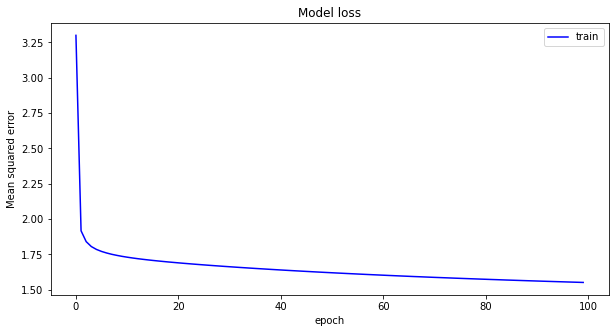

In [83]:
mod.history_plot()

Bây giờ ta có thể dùng method Summary để lấy nội dung betas và etas:

In [84]:
fe_df, re_df = mod.Summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4112)         0                                            
__________________________________________________________________________________________________
Fixed_effect (Dense)            (None, 1)            10          input_1[0][0]                    
__________________________________________________________________________________________________
Random_Effect (Dense)           (None, 1)            4112        input_2[0][0]                    
____________________________________________________________________________________________

Nội dung betas như sau:

In [85]:
fe_df

,Keras_GLMM
Intercept,3.186542
Stud_Age[T.4],0.053660
Stud_Age[T.6],0.062380
Stud_Age[T.8],0.141339
Lect_Age[T.2],-0.067621
Lect_Age[T.3],-0.107238
Lect_Age[T.4],-0.167474
Lect_Age[T.5],-0.154622
Lect_Age[T.6],-0.230838
Service[T.1],-0.094988


Ta thấy rằng kết quả này rất gần với fixed effect của R với package lme4

Còn đây là 4112 giá trị của random effects (tương ứng với mỗi hàng trong matrix Z)

In [86]:
re_df

0       0.023151
1      -0.015272
2       0.017752
3       0.011739
4      -0.008241
          ...   
4107   -0.113134
4108    0.034460
4109    0.157137
4110    0.017055
4111    0.145813
Length: 4112, dtype: float32

Trong python, ta có thể dựng GLMM bằng package statsmodel, tuy nhiên có giới hạn là chỉ chấp nhận 1 random effect duy nhất, ta không thể code các loại cross, nested random effects cho nhiều biến

In [87]:
import statsmodels.formula.api as smf

In [89]:
formula = "Score ~ Stud_Age + Lect_Age + Service"

md = smf.mixedlm(formula, df, groups=df["Student"])

mdf = md.fit()

mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: Score       
No. Observations: 73421   Method:             REML        
No. Groups:       2972    Scale:              1.6654      
Min. group size:  1       Log-Likelihood:     -124203.2237
Max. group size:  92      Converged:          Yes         
Mean group size:  24.7                                    
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       3.283    0.016 198.950 0.000  3.250  3.315
Stud_Age[T.4]   0.074    0.022   3.288 0.001  0.030  0.118
Stud_Age[T.6]   0.093    0.022   4.179 0.000  0.050  0.137
Stud_Age[T.8]   0.175    0.024   7.340 0.000  0.128  0.222
Lect_Age[T.2]  -0.087    0.014  -6.214 0.000 -0.114 -0.059
Lect_Age[T.3]  -0.150    0.017  -9.009 0.000 -0.182 -0.117
Lect_Age[T.4]  -0.198    0.018 -11.065 0.000 -0.233 -0.163
Lect_Age[T.5]  -0.188    0.021  -9.159 0.000 -0.229 -0.148
Lect_Age[T.6]  -0.288    0.018 -15.992 0.000 -0.323 -0.253
Service[T.1]   -0.092    0.010  -9.017 0.000 -0.112 -0.072
Group Var       0.101    0.004                            
==========================================================

"""

Ta có thể so sánh nội dung fixed effect betas của 2 mô hình Neural network Keras và GLMM của statsmodel, chúng tương tự nhau:

In [90]:
fe_df['GLMM'] = mdf.fe_params

fe_df

,Keras_GLMM,GLMM
Intercept,3.186542,3.282506
Stud_Age[T.4],0.053660,0.073679
Stud_Age[T.6],0.062380,0.093308
Stud_Age[T.8],0.141339,0.175263
Lect_Age[T.2],-0.067621,-0.086601
Lect_Age[T.3],-0.107238,-0.149557
Lect_Age[T.4],-0.167474,-0.198324
Lect_Age[T.5],-0.154622,-0.188271
Lect_Age[T.6],-0.230838,-0.287835
Service[T.1],-0.094988,-0.091856


Bài thực hành đến đây là hết, xin tạm biệt và hẹn gặp lại :)